In [1]:
import warnings
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import pandas as pd
import polars as pl
pl.enable_string_cache(True)

warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from feature_engine.wrappers import SklearnTransformerWrapper

from feature_engine.encoding import OrdinalEncoder
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import DropFeatures

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from darts.models.forecasting.nhits import NHiTSModel
from darts.timeseries import TimeSeries

seed=42

In [2]:
district='Beşiktaş'

train = (
    pl.concat([
        (
            pl.read_parquet("datasets/19_model/train.zstd")
            .filter(pl.col('DISTRICT').eq(district))
        ),
        (
            pl.read_parquet("datasets/19_model/valid.zstd")
            .filter(pl.col('DISTRICT').eq(district))
        )
    ], how='vertical')
    .drop('DISTRICT')
    .sort(['DATE_TIME', 'GEOHASH'])
    .to_pandas()
    .set_index('DATE_TIME')
    .assign(GEOHASH=lambda x: x['GEOHASH'].astype("object").astype("category"))
)

train.head()

GEOHASH  NUMBER_OF_VEHICLES LOCATION_TYPE  CITIZEN_RETURN  \
DATE_TIME                                                              
2020-01-01  sxk9st                  69        street          627933   
2020-01-01  sxk9kp                 109        avenue          627933   
2020-01-01  sxk9s3                 170        street          627933   
2020-01-01  sxk9s7                 121        street          627933   
2020-01-01  sxk9sk                 169        street          627933   

            CITIZEN_ARRIVAL  TOURIST_ARRIVAL    HOLIDAY_NAME  \
DATE_TIME                                                      
2020-01-01           692729          1017034  New Year's Day   
2020-01-01           692729          1017034  New Year's Day   
2020-01-01           692729          1017034  New Year's Day   
2020-01-01           692729          1017034  New Year's Day   
2020-01-01           692729          1017034  New Year's Day   

                HOLIDAY_TYPE SCHOOL_HOLIDAY_TYPE  HIGHWAY_TRNSPRT_PSNGRS  ...  \
DATE_TIME                                                                 ...   
2020-01-01  National holiday  Christmas holidays                   15430  ...   
2020-01-01  National holiday  Christmas holidays                   15430  ...   
2020-01-01  National holiday  Christmas holidays                   15430  ...   
2020-01-01  National holiday  Christmas holidays                   15430  ...   
2020-01-01  National holiday  Christmas holidays                   15430  ...   

            NEARBY_ISBIKE_STANDS_CNT  NEARBY_BIKE_MM_PARKING_CNT  TEMP  PRCP  \
DATE_TIME                                                                      
2020-01-01                         0                           0   4.6   0.0   
2020-01-01                         0                           0   4.6   0.0   
2020-01-01                         1                           0   4.6   0.0   
2020-01-01                         0                           0   4.6   0.0   
2020-01-01                         0                           1   4.6   0.0   

            TD_LAG1  TD_LAG24  TD_LAG168  PRCP_LAG1  PRCP_LAG2  PRCP_LAG3  
DATE_TIME                                                                  
2020-01-01       69        69         69        0.0        0.0        0.0  
2020-01-01      109       109        109        0.0        0.0        0.0  
2020-01-01      170       170        170        0.0        0.0        0.0  
2020-01-01      121       121        121        0.0        0.0        0.0  
2020-01-01      169       169        169        0.0        0.0        0.0  

[5 rows x 32 columns]

In [3]:
test = (
    pl.read_parquet("datasets/19_model/test.zstd")
    .filter(pl.col('DISTRICT').eq(district))
    .drop('DISTRICT')
    .sort(['DATE_TIME', 'GEOHASH'])
    .to_pandas()
    .set_index('DATE_TIME')
    .assign(GEOHASH=lambda x: x['GEOHASH'].astype("object").astype("category"))
)

test.head()

GEOHASH  NUMBER_OF_VEHICLES LOCATION_TYPE  CITIZEN_RETURN  \
DATE_TIME                                                              
2023-04-01  sxk9st                  45        street          628203   
2023-04-01  sxk9kp                  93        avenue          628203   
2023-04-01  sxk9s3                 164        street          628203   
2023-04-01  sxk9s7                 103        street          628203   
2023-04-01  sxk9sk                 118        street          628203   

            CITIZEN_ARRIVAL  TOURIST_ARRIVAL        HOLIDAY_NAME  \
DATE_TIME                                                          
2023-04-01           641667          1289903  Ramadan Observance   
2023-04-01           641667          1289903  Ramadan Observance   
2023-04-01           641667          1289903  Ramadan Observance   
2023-04-01           641667          1289903  Ramadan Observance   
2023-04-01           641667          1289903  Ramadan Observance   

                  HOLIDAY_TYPE SCHOOL_HOLIDAY_TYPE  HIGHWAY_TRNSPRT_PSNGRS  \
DATE_TIME                                                                    
2023-04-01  Ramadan Observance         Non Holiday                   14754   
2023-04-01  Ramadan Observance         Non Holiday                   14754   
2023-04-01  Ramadan Observance         Non Holiday                   14754   
2023-04-01  Ramadan Observance         Non Holiday                   14754   
2023-04-01  Ramadan Observance         Non Holiday                   14754   

            ...  NEARBY_ISBIKE_STANDS_CNT  NEARBY_BIKE_MM_PARKING_CNT  TEMP  \
DATE_TIME   ...                                                               
2023-04-01  ...                         0                           0  11.3   
2023-04-01  ...                         0                           0  11.3   
2023-04-01  ...                         1                           0  11.3   
2023-04-01  ...                         0                           0  11.3   
2023-04-01  ...                         0                           1  11.3   

            PRCP  TD_LAG1  TD_LAG24  TD_LAG168  PRCP_LAG1  PRCP_LAG2  \
DATE_TIME                                                              
2023-04-01   0.0       74        31         23        0.0        0.0   
2023-04-01   0.0       89        74         56        0.0        0.0   
2023-04-01   0.0      187       129         95        0.0        0.0   
2023-04-01   0.0      127        80         61        0.0        0.0   
2023-04-01   0.0      162        99         69        0.0        0.0   

            PRCP_LAG3  
DATE_TIME              
2023-04-01        0.0  
2023-04-01        0.0  
2023-04-01        0.0  
2023-04-01        0.0  
2023-04-01        0.0  

[5 rows x 32 columns]

In [4]:
print(len(train))
print(len(test))

768528
19440


In [5]:
to_drop = [col for col in train.columns if ("TD_LAG" not in col) and col not in ['GEOHASH', 'NUMBER_OF_VEHICLES']]
to_drop

['LOCATION_TYPE',
 'CITIZEN_RETURN',
 'CITIZEN_ARRIVAL',
 'TOURIST_ARRIVAL',
 'HOLIDAY_NAME',
 'HOLIDAY_TYPE',
 'SCHOOL_HOLIDAY_TYPE',
 'HIGHWAY_TRNSPRT_PSNGRS',
 'SEA_TRNSPRT_PSNGRS',
 'RAIL_TRNSPRT_PSNGRS',
 'IS_COVID_RESTRICTION',
 'FOOTBALL_STADIUM_STATUS',
 'NEARBY_LANDMARKS_CNT',
 'NEARBY_PARKING_CAPACITY',
 'NEARBY_TAXI_STND_CNT',
 'NEARBY_MINIBUS_STOPS_CNT',
 'NEARBY_FERRIES_CNT',
 'NEARBY_METRO_STNS_CNT',
 'NEARBY_BUS_STOP_CNT',
 'NEARBY_FUEL_STNS_CNT',
 'NEARBY_ISBIKE_STANDS_CNT',
 'NEARBY_BIKE_MM_PARKING_CNT',
 'TEMP',
 'PRCP',
 'PRCP_LAG1',
 'PRCP_LAG2',
 'PRCP_LAG3']

In [6]:
num_cols = [col for col in train.columns if "TD_LAG" in col]
num_cols

['TD_LAG1', 'TD_LAG24', 'TD_LAG168']

In [7]:
# to_drop
dropfeats = DropFeatures(to_drop)

# MinMaxScaler
scaler=SklearnTransformerWrapper(transformer=MinMaxScaler(), variables=num_cols)

#Creating encoder pipeline
encoders = make_pipeline(
    (dropfeats), # drop columns
    (scaler) # scaler
)

In [8]:
transform_train = encoders.fit_transform(train)
transform_train.head()

GEOHASH  NUMBER_OF_VEHICLES   TD_LAG1  TD_LAG24  TD_LAG168
DATE_TIME                                                            
2020-01-01  sxk9st                  69  0.086076  0.086076   0.086076
2020-01-01  sxk9kp                 109  0.136709  0.136709   0.136709
2020-01-01  sxk9s3                 170  0.213924  0.213924   0.213924
2020-01-01  sxk9s7                 121  0.151899  0.151899   0.151899
2020-01-01  sxk9sk                 169  0.212658  0.212658   0.212658

In [9]:
y_all = TimeSeries.from_group_dataframe(transform_train.reset_index(),
                                        time_col='DATE_TIME',
                                        group_cols='GEOHASH',
                                        value_cols='NUMBER_OF_VEHICLES')

past_cov = TimeSeries.from_group_dataframe(transform_train.reset_index(),
                                           time_col='DATE_TIME',
                                           group_cols='GEOHASH',
                                           value_cols=['TD_LAG1', 'TD_LAG24', 'TD_LAG168'])

In [10]:
nhits_model = NHiTSModel(input_chunk_length=20424,
                         output_chunk_length=8040,
                         random_state=seed)

In [11]:
nhits_model.fit(series=y_all, past_covariates=past_cov)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 102 M 
---------------------------------------------------
60.5 M    Trainable params
41.9 M    Non-trainable params
102 M     Total params
409.541   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


NHiTSModel(num_stacks=3, num_blocks=1, num_layers=2, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=20424, output_chunk_length=8040, random_state=42)

In [12]:
forecasts = nhits_model.predict(n=720, series=y_all, past_covariates=past_cov)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

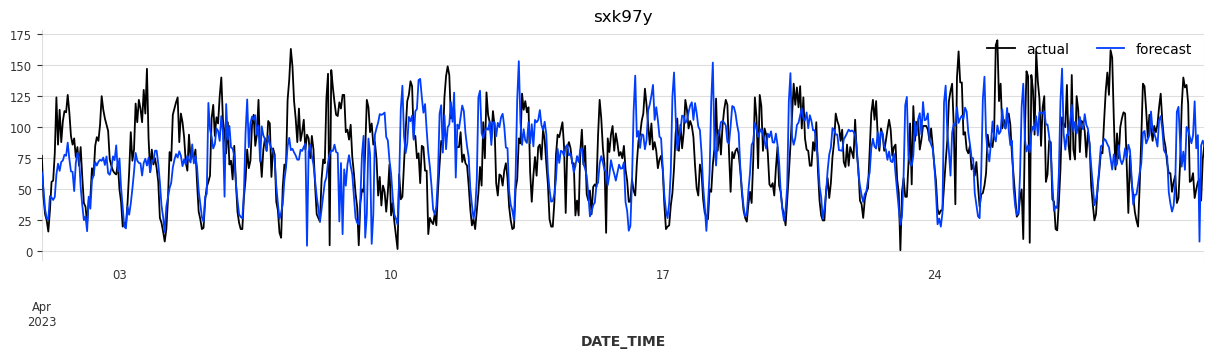

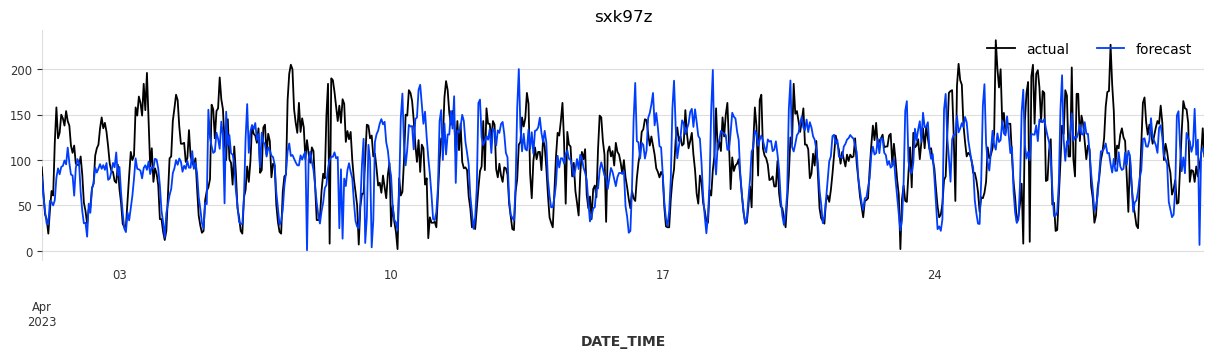

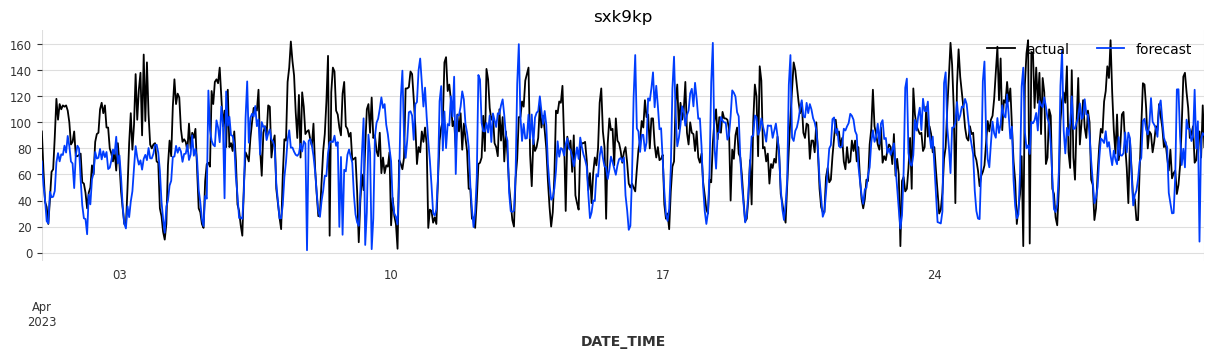

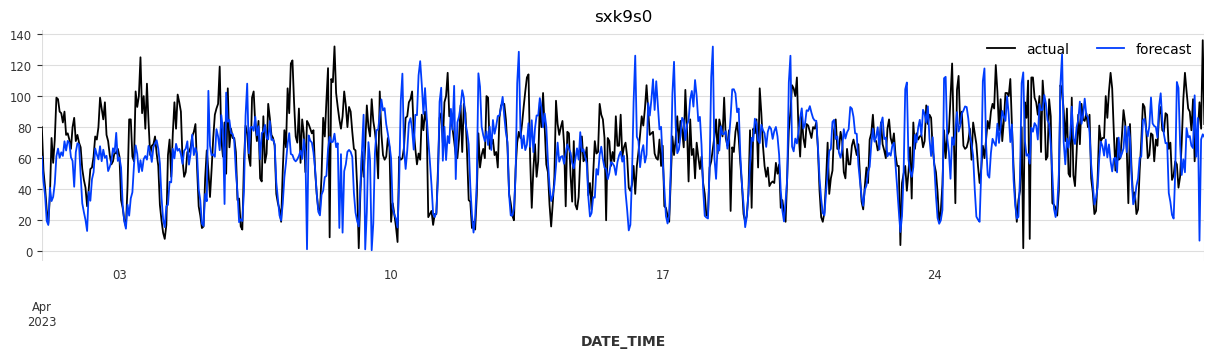

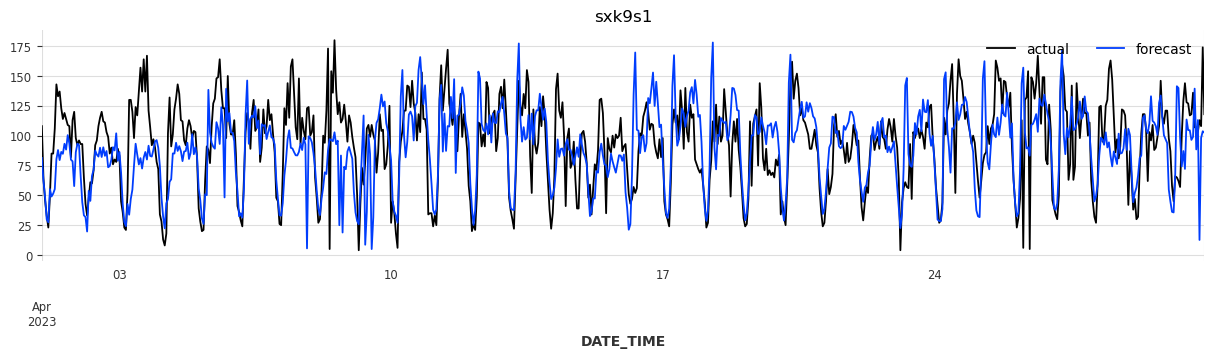

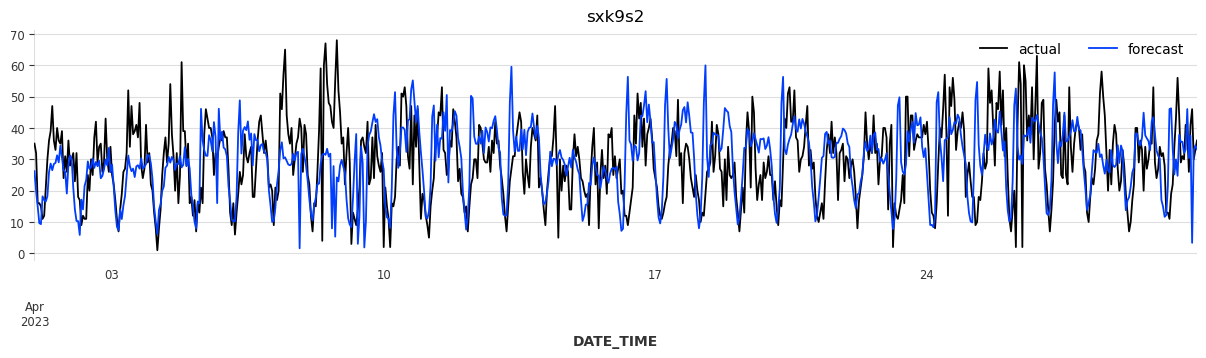

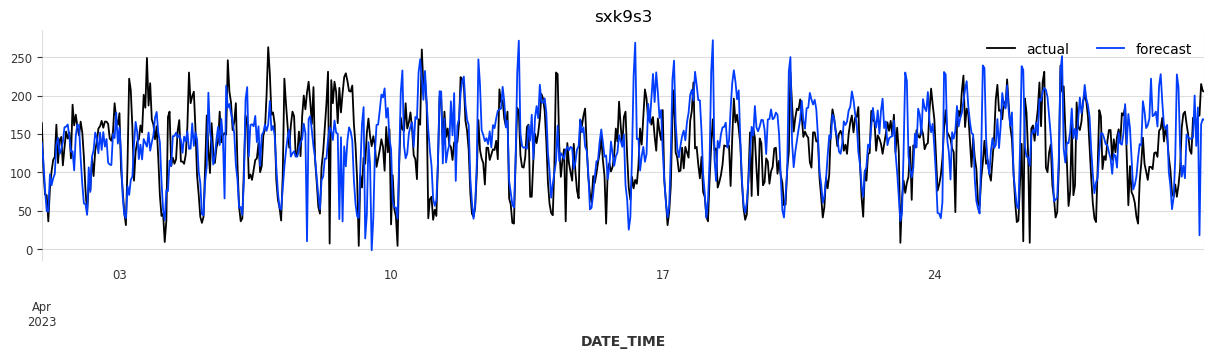

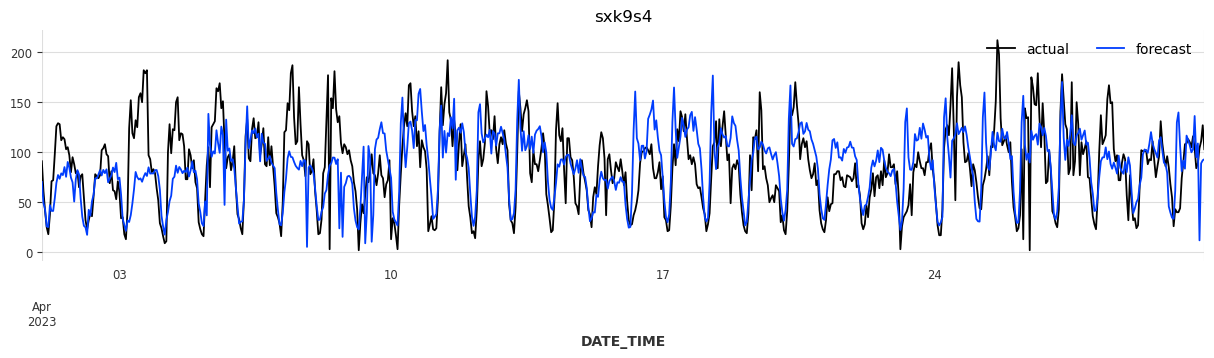

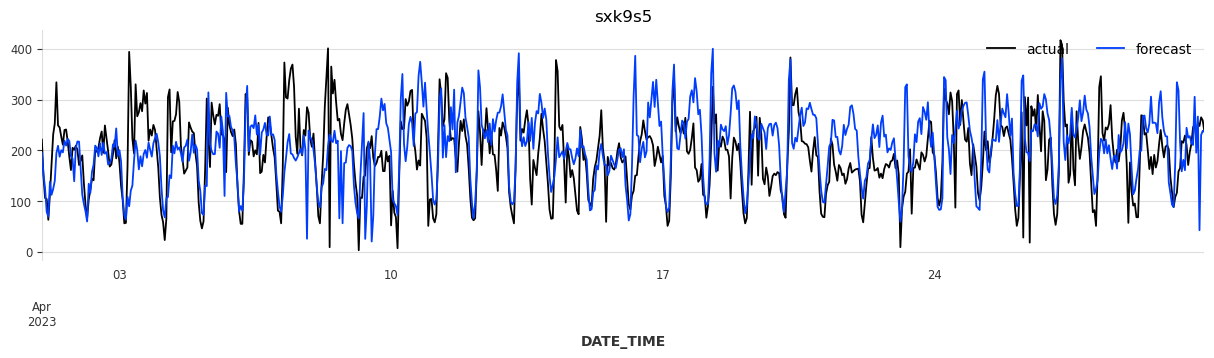

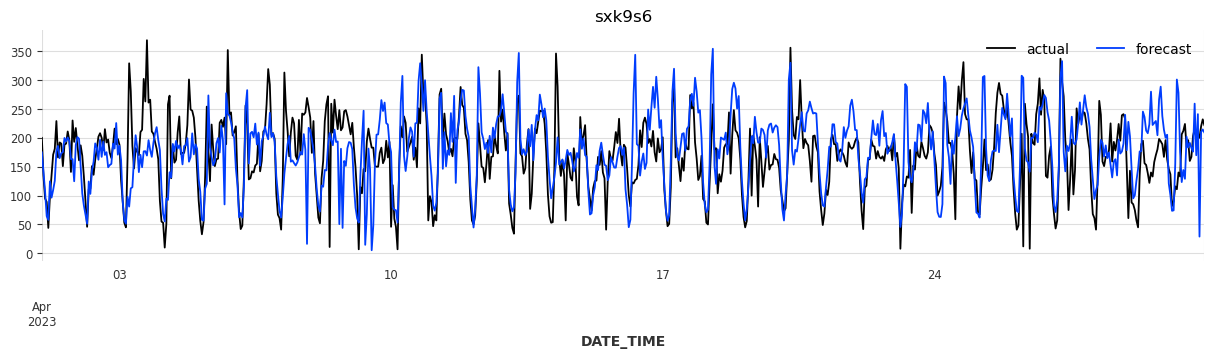

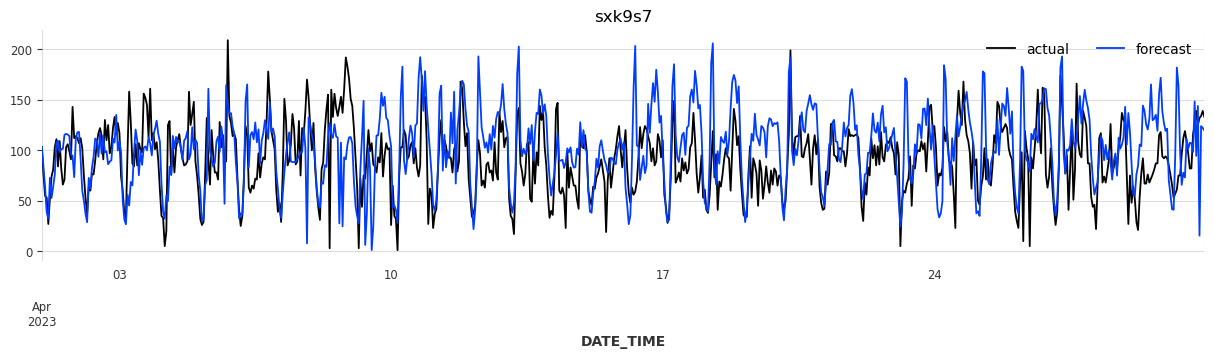

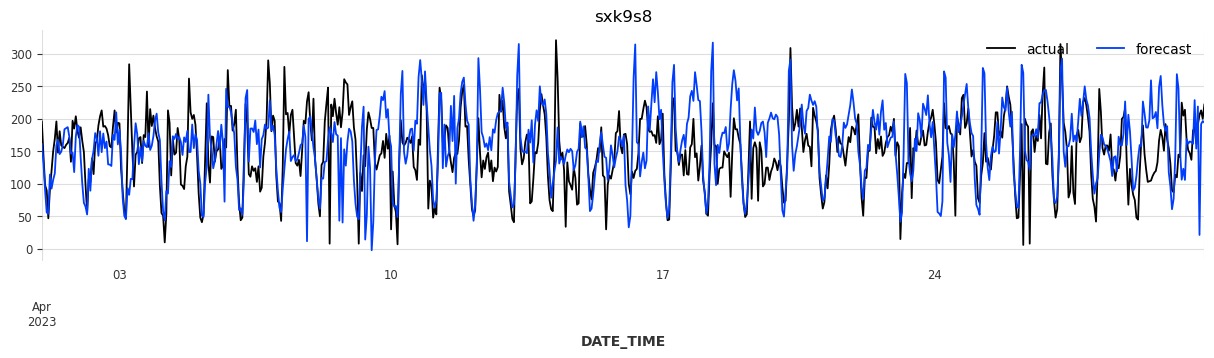

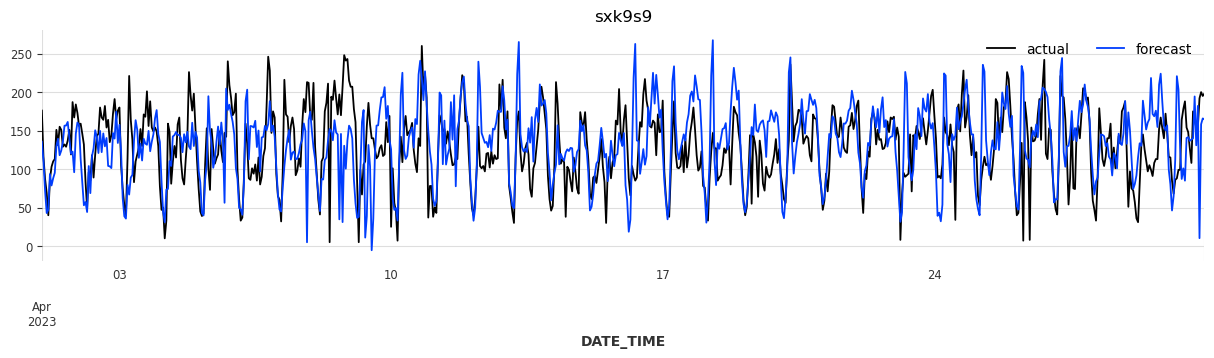

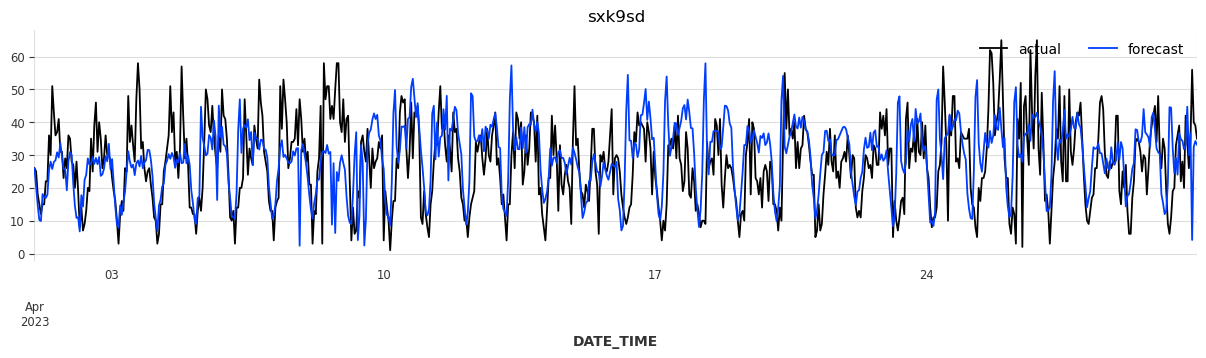

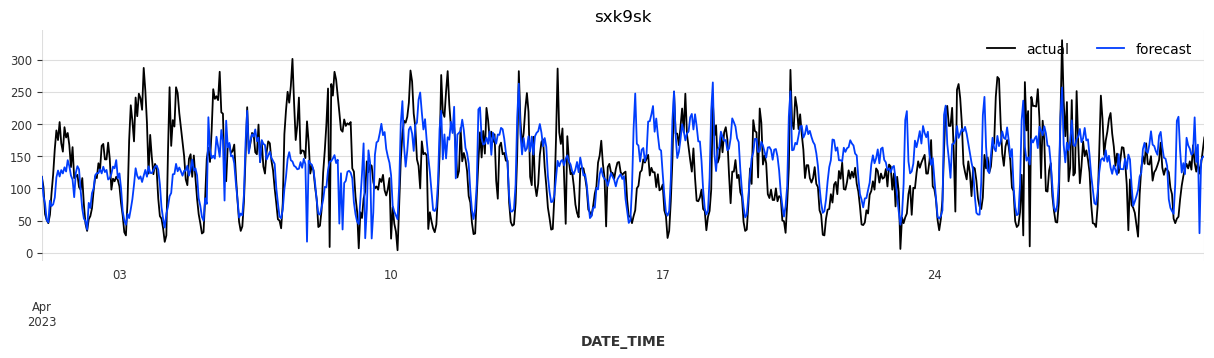

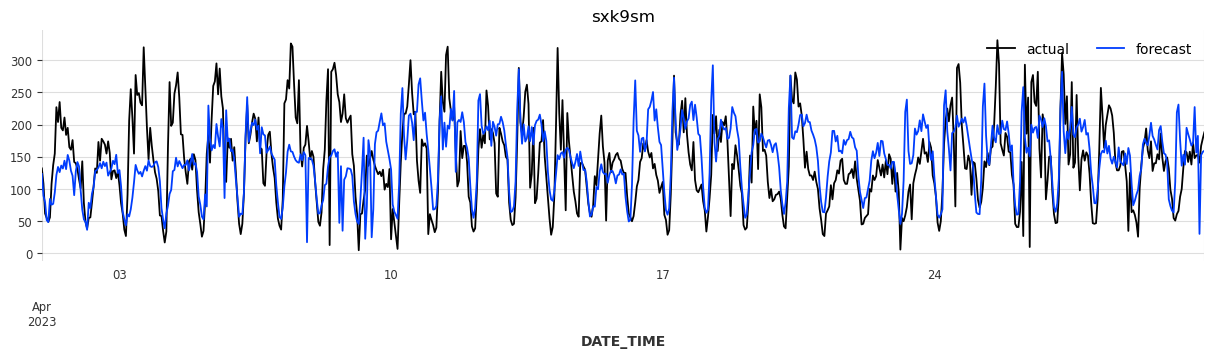

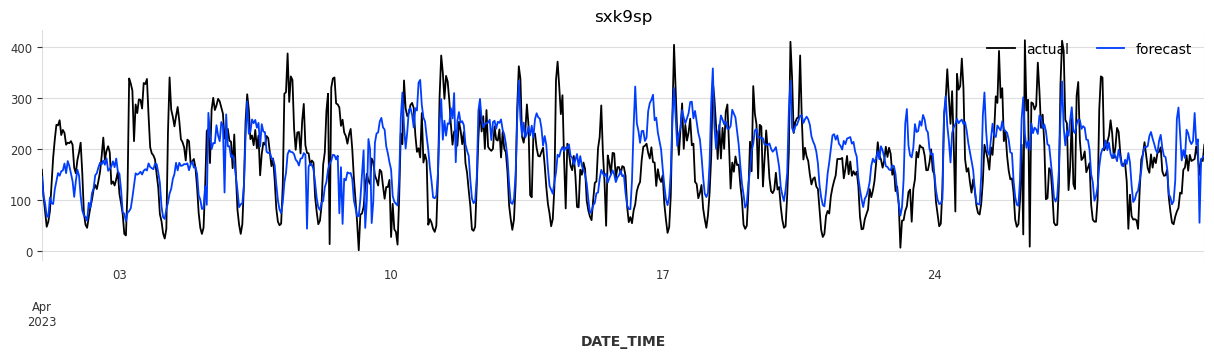

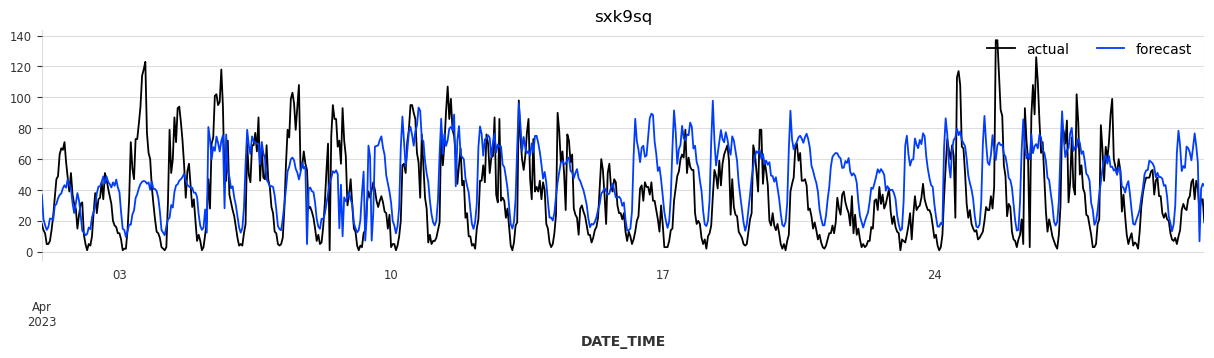

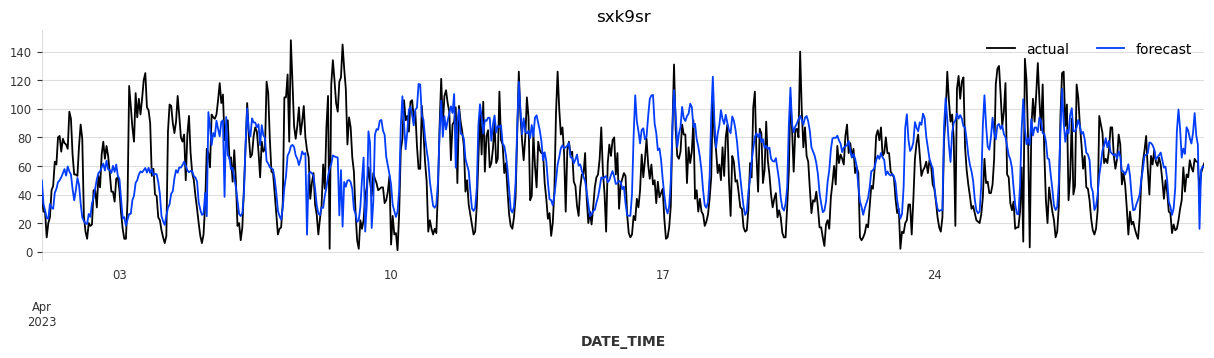

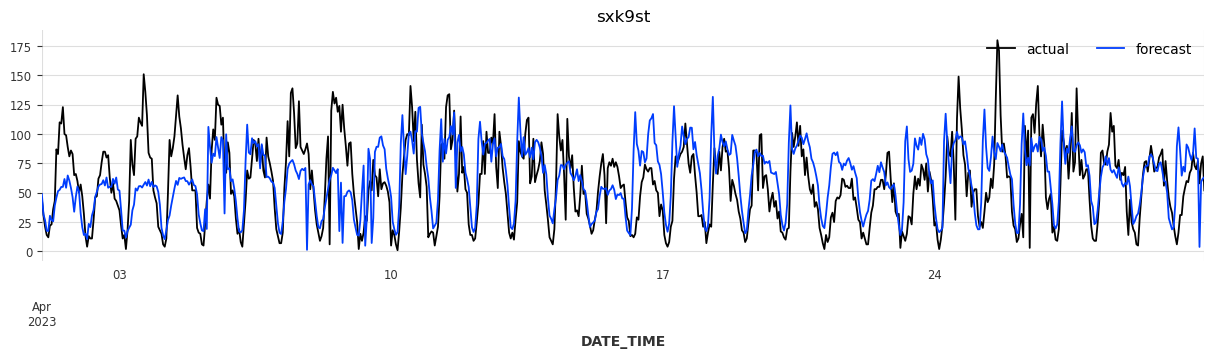

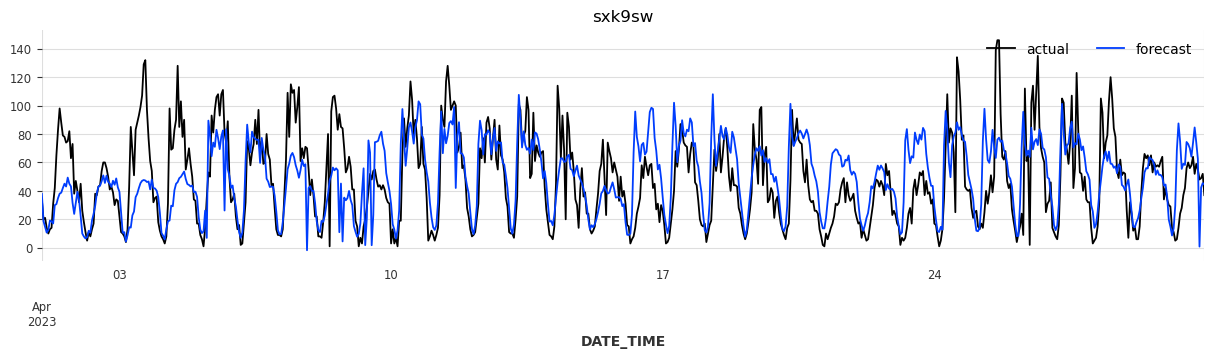

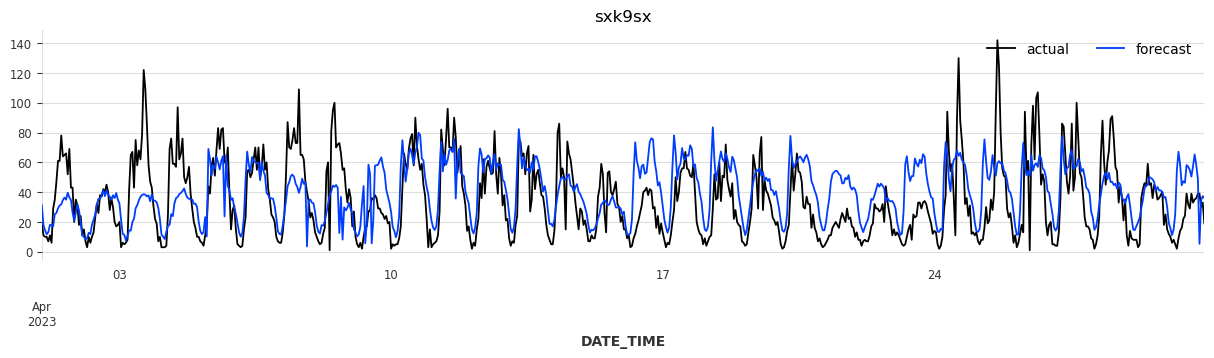

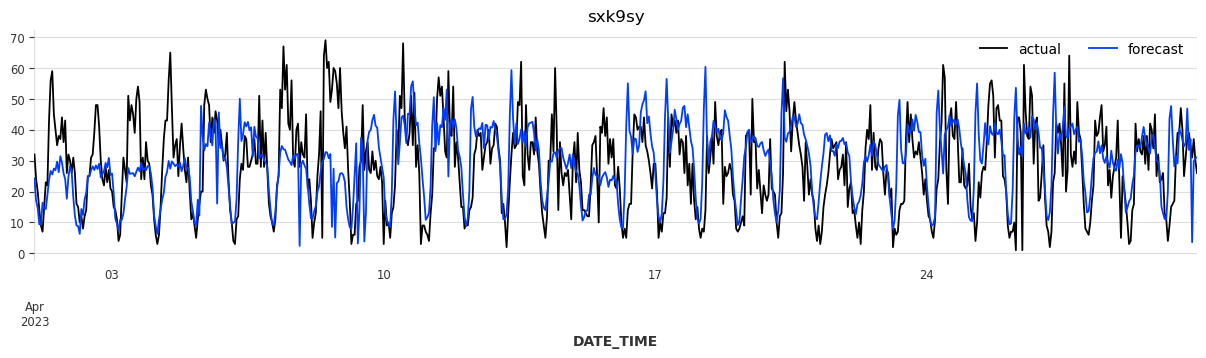

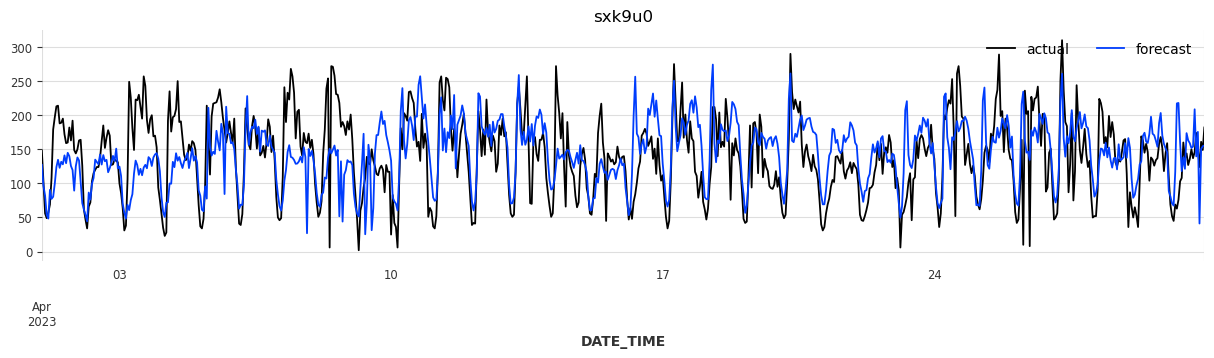

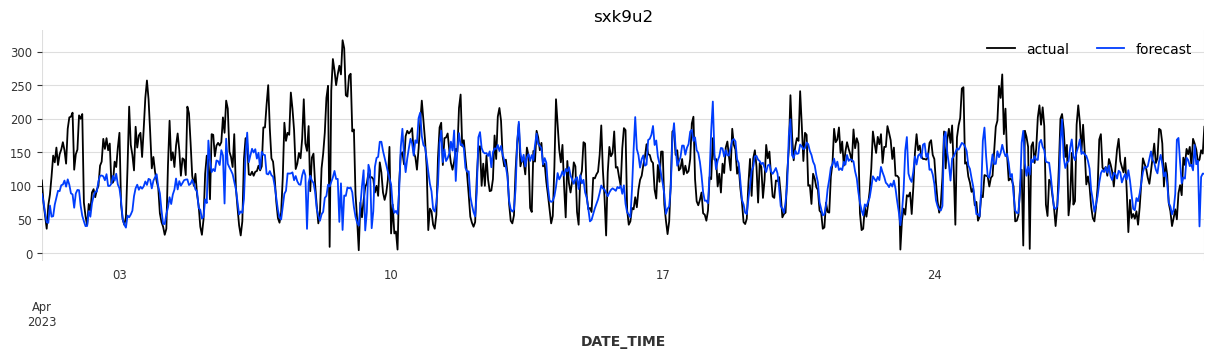

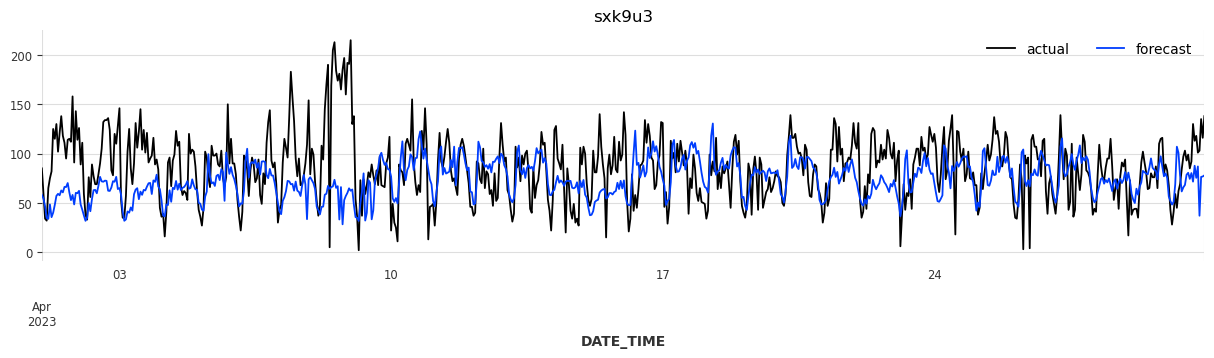

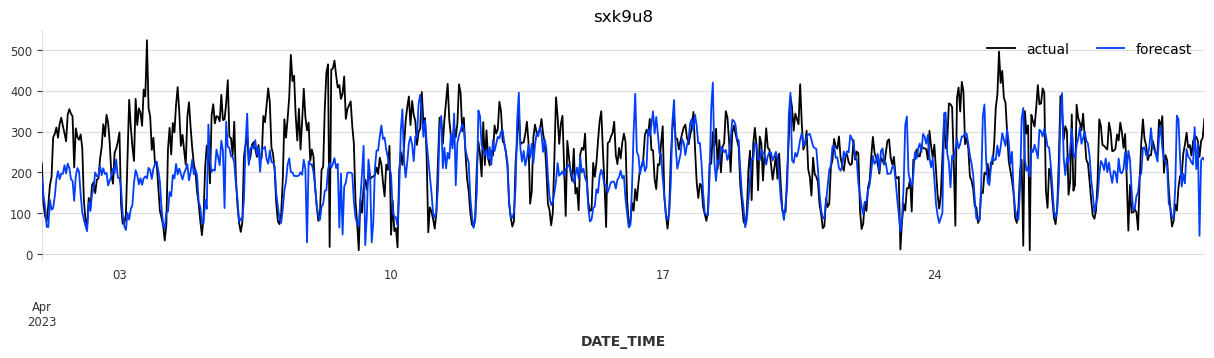

In [13]:
for i in range(len(y_all)):

    gh = forecasts[i].static_covariates_values()[0][0]

    ax = (
        test.query(f"GEOHASH=='{gh}'")['NUMBER_OF_VEHICLES']
        .plot(figsize=(15, 3), label='actual')
    )

    forecasts[i].pd_series().plot(figsize=(15, 3), label='forecast', ax=ax)

    ax.set_title(gh)
    ax.legend(ncol=2, loc='upper right')
    plt.show();

In [14]:
def create_actual_forecast_df(idx):
    
    gh = forecasts[idx].static_covariates_values()[0][0]

    temp_df = (
        forecasts[idx]
        .pd_dataframe()
        .rename(columns={"NUMBER_OF_VEHICLES" : "forecasts"})
        .assign(GEOHASH=gh)
    )

    temp_df['actual'] = test.query(f"GEOHASH=='{gh}'")['NUMBER_OF_VEHICLES']

    return temp_df

In [15]:
test_forecast_df = pd.concat((create_actual_forecast_df(idx=i) for i in range(len(forecasts))))

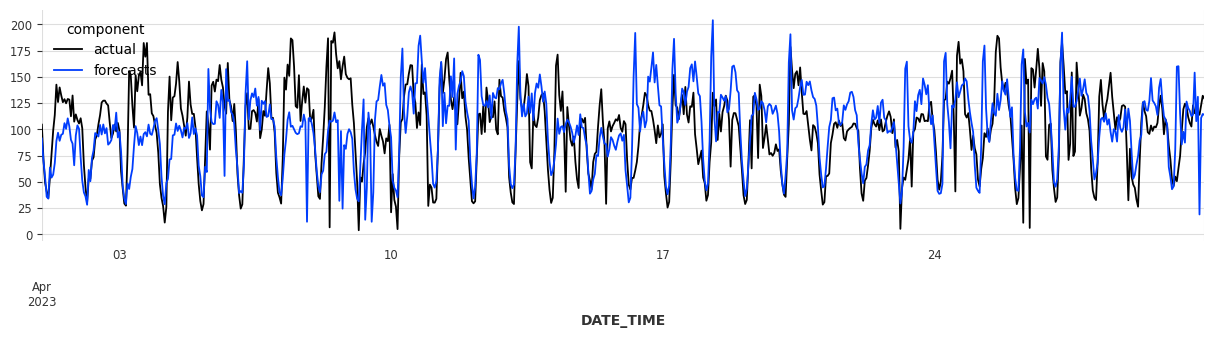

In [21]:
(
    test_forecast_df
    .resample('H')['actual', 'forecasts'].mean()
    .plot(y=['actual', 'forecasts'], figsize=(15, 3))
);

In [16]:
mean_squared_error(y_true=test_forecast_df['actual'],
                   y_pred=test_forecast_df['forecasts'],
                   squared=False)

45.5750272264211

In [17]:
(
    test_forecast_df
    .groupby('GEOHASH')
    .apply(lambda x: mean_squared_error(y_true=x['actual'], y_pred=x['forecasts'], squared=False))
    .sort_values()
)

GEOHASH
sxk9sd    12.866615
sxk9s2    12.907429
sxk9sy    13.366333
sxk9sx    22.066869
sxk9s0    25.373514
sxk9sq    25.661254
sxk9sw    25.741092
sxk9sr    27.722133
sxk9st    29.548933
sxk9kp    31.545202
sxk97y    31.629599
sxk9s1    32.658562
sxk9s4    34.546986
sxk9u3    36.494080
sxk9s7    38.712712
sxk97z    41.082502
sxk9s3    48.448009
sxk9s9    48.808709
sxk9u2    51.874065
sxk9u0    52.996033
sxk9sk    55.276251
sxk9s8    55.853339
sxk9s6    60.077981
sxk9sm    60.924113
sxk9sp    71.955512
sxk9s5    73.696038
sxk9u8    91.483170
dtype: float64